# Get and interpret GitHub jobs data

_(Skip to **Challenge 3** if you came here from the ChiPy Coding Workshops readme)_ This Notebook acesses the [GitHub Jobs page](https://jobs.github.com) API for a first look at data acqusition and analysis through web APIs.

Tonight's project uses the very popular Python HTTP library [requests](https://2.python-requests.org/en/master/). You will explore the data in the jobs API with the intent of learning something about the current job market for devs. There are a ton of caveats here: for example,

* Who chooses to post to GitHub Jobs? Are they representative of the overall population?
* How old are the postings?
* Is it safe to extrapolate statistics to the country? to Illinois? to Chicago?


## Side note
For my own long-term employment I like to keep an eye on what skills and roles are in demand. Taking multiple snapshots like this over the year can give a sense of when companies like to hire, and for what -- Regional variation and your geographic preferences may be worth considering.


## Challenge 2
At this point hopefully you wrote your own code to get the data. Feel free to paste that in this notebook. (we're using Google Colab, a Google-specific Jupyter notebook, to avoid installing plotting libraries to everyone's different environment.)


## Setup
You may like this cool library UpsetPlot, a Python version of [Caleydo's UpsetPlot](https://caleydo.org/tools/upset/). It allows you to plot multiple set intersections (like a Venn Diagram on steroids) -- I thought it might be useful for you here so it's `!pip installed` at beginning of the notebook (the exclamation point in the context of a Google Colab notebook will run this command in the shell that is running underneath the Notebook environment.)

These other libraries are suggestions...do what you want!

In [0]:
!pip install --quiet upsetplot

# Python standard libraries
import json  # Just to catch the JSONDecodeError
import re
from collections import Counter, namedtuple

import requests



We can get straight at it:

In [4]:
# Chicago
data = requests.get("https://jobs.github.com/positions.json?&location=Chicago").json()
print(f"{len(data)} Chicago jobs found:\n  ", ", ".join(d["title"] for d in data))

# Illinois
data = requests.get("https://jobs.github.com/positions.json?&location=Illinois").json()
print(f"{len(data)} Illinois jobs found:\n  ", ", ".join(d["title"] for d in data))

# USA
i = 0
results = []
while True:
    url = f"https://jobs.github.com/positions.json?&location=usa&page={i}"
    i = i + 1
    try:
        data = requests.get(url).json()
        results.extend(data)
    except json.decoder.JSONDecodeError:
        data = []
    if len(data) < 50 or len(results) > 1000:
        break  # Finished all pulls
        
print(f"\nPulled {len(results)} U.S. positions.")

8 Chicago jobs found:
   Salesforce Engineer, Full Stack Ruby Developer, Full Stack Software Engineer, Solutions Engineer, Lead Full Stack Web Engineer, .Net/Azure Developer , Front End Developer, Senior Python Engineer
8 Illinois jobs found:
   Salesforce Engineer, Full Stack Ruby Developer, Full Stack Software Engineer, Solutions Engineer, Lead Full Stack Web Engineer, .Net/Azure Developer , Front End Developer, Senior Python Engineer

Pulled 199 U.S. positions.


### Try walking through the dataset
Like what's there?

In [5]:
print("The dictionary keys\n" + ("*" * 20))
print(results[0].keys())

print("\n\nCompany that's hiring\n" + ("*" * 20))
print(Counter(result['company'] for result in results).most_common())

The dictionary keys
********************
dict_keys(['id', 'type', 'url', 'created_at', 'company', 'company_url', 'location', 'title', 'description', 'how_to_apply', 'company_logo'])


Company that's hiring
********************
[('Bloom Insurance', 12), ('Apple Inc.', 11), ('Knotch', 6), ('Livongo', 6), ('Game Closure', 6), ('Leia Inc.', 4), ('PIMCO', 4), ('OppLoans', 4), ('Achievement Network (ANet)', 4), ('NinthDecimal', 4), ('The Rock Creek Group', 4), ('Avanade', 3), ('Thorlabs, Inc.', 3), ('UtopiaCompression Corporation', 2), ('charter solutions', 2), ('Visa', 2), ('WHRO Public Media', 2), ('CircleCI', 2), ('CrowdTwist', 2), ('MRS Electronic, Inc.', 2), ('Fortitude Development', 2), ('American Physical Society', 2), ('Aligned Meetings', 2), ('one-G simulation', 2), ('Working Title Co.', 2), ('Expeditors', 2), ('BODIS', 2), ('Arable Labs ', 2), ('TrueMotion', 2), ('CU Direct', 2), ('Exclamation Labs', 2), ('InQuest', 2), ('Veo Robotics', 2), ('2ULaundry', 2), ('Acadian Asset Managem

### Looking for patterns

- Simple string search for languages

In [6]:
print(f"{len(results)} total GitHub jobs")

print()
print("*" * 20)
print("LANGUAGES -- with double counting")
    
for language in ("javascript", "python", "sql", "java", "c++", "scala", "ruby"):
    if language == "java":
        total_jobs = len([r for r in results if language in r['description'].lower() and not "javascript" in r['description'].lower()])
    else:
        total_jobs = len([r for r in results if language in r['description'].lower()])
    print(f"{language}: {total_jobs} jobs ({total_jobs / len(results):.0%})")


199 total GitHub jobs

********************
LANGUAGES -- with double counting
javascript: 105 jobs (53%)
python: 63 jobs (32%)
sql: 97 jobs (49%)
java: 20 jobs (10%)
c++: 19 jobs (10%)
scala: 58 jobs (29%)
ruby: 32 jobs (16%)


### Try a really simple regex to guess what kind of role

This list came from hours of manully looking at all the job listings to find common strings. No magic.

In [38]:
import re

roles = [
    ("managers", re.compile("(manager|director)", re.IGNORECASE)),
    ("ops", re.compile("dev.?ops", re.IGNORECASE)),
    ("full stack", re.compile("full.?stack", re.IGNORECASE)),
    ("front end", re.compile("(front.?end|php)", re.IGNORECASE)),
    ("backend", re.compile("(back.?end|sql)", re.IGNORECASE)),
    ("quality", re.compile("(q.?a|quality.a)", re.IGNORECASE)),
    ("security", re.compile("(security|devsec|opsec)", re.IGNORECASE)),
    ("data science", re.compile("(data.?scien|machine.?lear)", re.IGNORECASE)),
    ("other dev", re.compile(".*", re.IGNORECASE)),
]


by_roles = {k:[] for k,v in roles}
for r in results:
    role = next(role for role, regex in roles if regex.search(r['description']))
    by_roles[role].append(r)
  

for role, jobs in by_roles.items():
     print(f"{role}: {len(jobs)} jobs  ({len(jobs) / len(results):.0%})")
  

managers: 57 jobs  (29%)
ops: 12 jobs  (6%)
full stack: 49 jobs  (25%)
front end: 21 jobs  (11%)
backend: 26 jobs  (13%)
quality: 21 jobs  (11%)
security: 2 jobs  (1%)
data science: 0 jobs  (0%)
other dev: 11 jobs  (6%)




## Challenge 3
Visualization! let's see what we can build...for example:

In [0]:
import pandas
##
# Here is the R version of upsetplot (from the original authors)
#   https://cran.r-project.org/web/packages/UpSetR/vignettes/basic.usage.html
import upsetplot

In [9]:
results[0]

{'company': 'UtopiaCompression Corporation',
 'company_logo': None,
 'company_url': None,
 'created_at': 'Wed Aug 14 23:57:29 UTC 2019',
 'description': '<p>UtopiaCompression is in need of a C++ Software Engineer, with current U.S. work authorization, to support R&amp;D and product development in multiple areas, including:</p>\n<ul>\n<li>Computer vision;</li>\n<li>Machine learning;</li>\n<li>Control and estimation applications for the air and maritime domains.\nThis role involves the implementation of state-of-the-art numerical algorithms on CPUs, GPUs, SoCs, and other embedded platforms.</li>\n</ul>\n<p>Basic Requirements</p>\n<ul>\n<li>BS/MS in Computer Science, Electrical Engineering, or related field;</li>\n<li>3 or more years of industry experience as C++ developer;</li>\n<li>Strong programming skills in Python and Golang;</li>\n<li>Extensive development experience in Linux environments;</li>\n<li>Experience with embedded platforms;</li>\n<li>Currently authorized to work in the U.

In [62]:
languages = sorted(["javascript", "python", "sql", "c++", "scala", "ruby"])
language_pattern = re.compile("({})".format("|".join(re.escape(lang) for lang in languages)))

index_names = ["language", "company", "location", "title"]
Row = namedtuple("Row", index_names)
one_row_per_language = []

for result in results:
    for language in language_pattern.findall(result["description"].lower()):
        new_row = Row(language, result["company"], result["location"], result["title"])
        one_row_per_language.append(new_row)


row_index = pandas.MultiIndex.from_tuples(one_row_per_language)
occurrences = [1] * len(one_row_per_language)
upsetplot_formatted_data = pandas.Series(occurrences, index=row_index)
upsetplot_formatted_data.index.names = index_names

# this was a pain. I made the data shape by following Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html


#for result in results:
    
        
df = pandas.DataFrame(
    {**dict.fromkeys(language_pattern.findall(row["description"].lower()), True),
     "company": row["company"],
     "location": row["location"],
     "title": row["title"]
    }
    for row in results)
df = df.fillna(False).set_index(languages)
df.head(3)

company  ...                                        title
c++   javascript python ruby  scala sql                                   ...                                             
True  False      True   False True  False  UtopiaCompression Corporation  ...                        C++ Software Engineer
                 False  False False False                      Leia Inc.  ...          Software Engineer, Video, Front End
False False      False  False False True               charter solutions  ...  FullStack Engineer - Jr. Level to Mid Level

[3 rows x 3 columns]

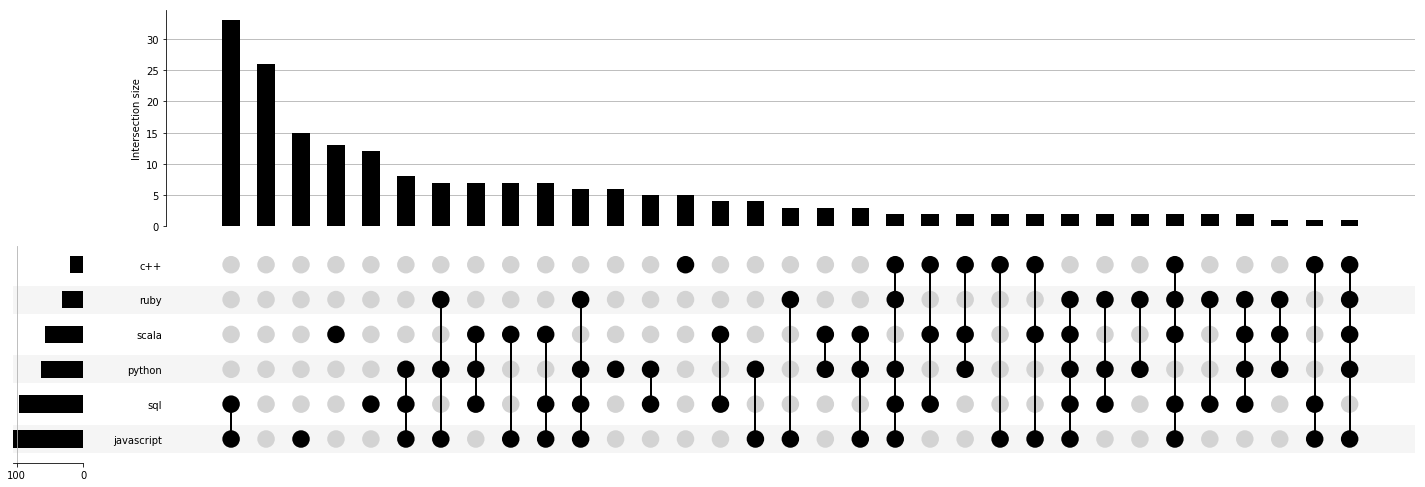

In [64]:
p = upsetplot.plot(
    df,
    element_size=50,  # point size of "side of element"
    subset_size="count",
    sort_by="cardinality"
);

p['intersections'].tick_params(labelsize="medium")
p['matrix'].tick_params(labelsize="medium")
#import matplotlib
#from google.colab import files
#current_figure = matplotlib.pyplot.gcf()
#current_figure.savefig("github_jobs_languages_only.png")
#files.download("github_jobs_languages_only.png")

# Library versions

In [65]:
import datetime
import sys

import pandas
import requests
import upsetplot

print(f"""
Date: {datetime.date.today()}
Python {sys.version}
Libraries:
- pandas {pandas.__version__}
- requests {requests.__version__}
- upsetplot {upsetplot.__version__}
""")


Date: 2019-08-15
Python 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Libraries:
- pandas 0.24.2
- requests 2.21.0
- upsetplot 0.3.0.post3

